<ipython-input-128-17120c1b6d0a>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
------------------------------
Augemented Dickey-Fuller Test
H0 : 단위근이 존재한다 (비정상 시계열)
Ha : 단위근이 없다 (정상 시계열)
Critical Values : {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
------------------------------
Test Statistics : -1.837661
p-value : 0.361931
------------------------------


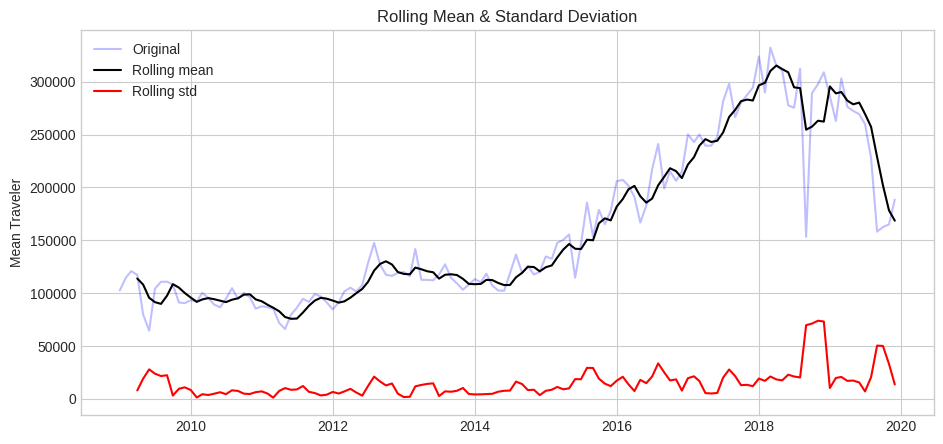

<Axes: xlabel='date'>

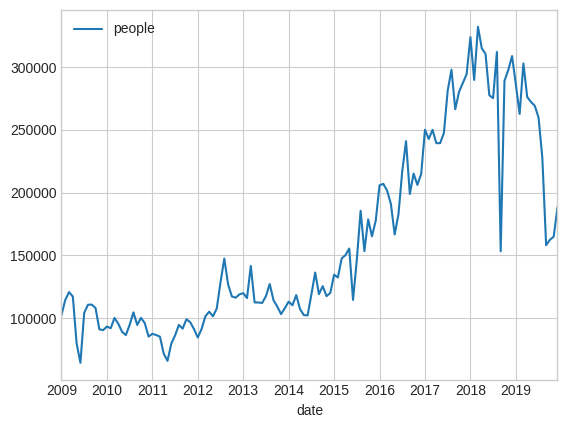

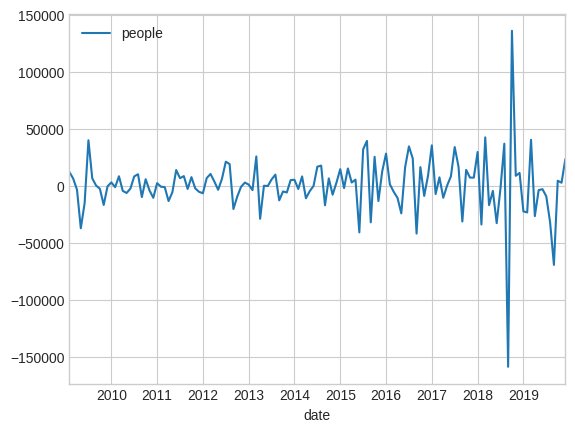

In [ ]:
!pip install pmdarima
!pip install prophet

import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('seaborn-whitegrid')
%matplotlib inline

import pmdarima as pm
from pmdarima.arima import auto_arima

from prophet import Prophet

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.dates import MonthLocator, DateFormatter

# Google Drive 연동
from google.colab import drive
drive.mount('/content/gdrive')


# 시각화 함수 정의
def plot_ts(data, color, alpha, label ,cityname):
    plt.figure(figsize=(11,5))
    plt.plot(data, color=color, alpha=alpha, label=label)
    plt.title(cityname)
    plt.ylabel('Travelers')
    plt.legend()
    plt.show()


def ADF_test(data):
	# ADF 실시
    results = adfuller(data, autolag='t-stat')

    # 통계량
    s = results[0]
    # p-value
    p = results[1]
    # 기각역
    cv = results[4]

    # 출력
    print('-'*30)
    print('Augemented Dickey-Fuller Test')
    print('H0 : 단위근이 존재한다 (비정상 시계열)')
    print('Ha : 단위근이 없다 (정상 시계열)')
    print('Critical Values : {}'.format(cv))
    print('-'*30)
    print('Test Statistics : {:.6f}'.format(s))
    print('p-value : {:.6f}'.format(p))
    print('-'*30)


def plot_rolling(data, roll_size):
    # 이동평균함수(rolling) - 평균, 표준편차
    roll_mean = data.rolling(window=roll_size).mean()
    roll_std = data.rolling(window=roll_size).std()

    # 시각화
    plt.figure(figsize=(11,5))
    plt.plot(data, color='blue', alpha=0.25, label='Original')
    plt.plot(roll_mean, color='black', label='Rolling mean')
    plt.plot(roll_std, color='red', label='Rolling std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel("Mean Traveler")
    plt.legend()
    plt.show()


def plot_and_error(data, forecast):
    # MSE 계산
    mse = mean_squared_error(data, forecast)
    # 시각화
    plt.figure(figsize=(11,5))
    plt.plot(data, color='blue', alpha=0.25 , label='Original')
    plt.plot(forecast, color='red', label='predicted')
    plt.title("Time Series Forecast")
    plt.ylabel("Mean Traveler")
    plt.legend()
    plt.show()
    # MSE 출력
    print('Mean Squared Error : {:.4f}'.format(mse))


# 데이터 불러오기
data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/bigdata/remove_city_under_5000_2.csv")

# 날짜 정보를 활용하여 연도와 월을 하나의 날짜 형식으로 변환
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

data = data[['city', 'date', 'people']]
data.set_index('date', inplace=True)

practice_data = data[data['city'] == '간사이']
practice_data = practice_data[['people']]
train_data = practice_data[(practice_data.index >= '2009-01-01') & (practice_data.index <= '2019-12-01')]
test_data = practice_data[practice_data.index >= '2020-01-01']

# ADF 실행해보기
ADF_test(train_data)

plot_rolling(train_data, 4)

train_data_diff = train_data.diff().dropna()

train_data.plot()
train_data_diff.plot()


In [ ]:
ADF_test(train_data_diff)

auto_arima_model = auto_arima(train_data, start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                              d=1, trace=True, error_action='ignore', supress_warnings=True, stepwise=False)

auto_arima_model.summary()

------------------------------
Augemented Dickey-Fuller Test
H0 : 단위근이 존재한다 (비정상 시계열)
Ha : 단위근이 없다 (정상 시계열)
Critical Values : {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
------------------------------
Test Statistics : -1.146176
p-value : 0.696311
------------------------------
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=3036.530, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=3018.991, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=3020.507, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=3022.093, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=3023.231, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=3020.120, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=3022.584, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=3023.743, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=3023.129, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=3022.064, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[1]

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1501.403
Date:                Wed, 06 Sep 2023   AIC                           3016.805
Time:                        07:09:18   BIC                           3036.932
Sample:                    01-01-2009   HQIC                          3024.984
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1000.6358   5617.177      0.178      0.859      -1e+04     1.2e+04
ar.L1         -1.7268      0.058    -29.993      0.000      -1.840      -1.614
ar.L2         -0.9854      0.057    -17.332      0.000      -1.097      -0.874
ma.L1          1.3909      0.087     15.930      0.000       1.220       1.562
ma.L2          0.4283      0.119      3.600      0.000       0.195       0.661
ma.L3         -0.2869      0.079     -3.644      0.000      -0.441      -0.133
sigma2      5.272e+08      0.400   1.32e+09      0.000    5.27e+08    5.27e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               676.85
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.26   Skew:                            -1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+24. Standard errors may be unstable.
"""

In [ ]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)

r2 = r2_score(test_data, predicted_value)

<Axes: xlabel='date'>

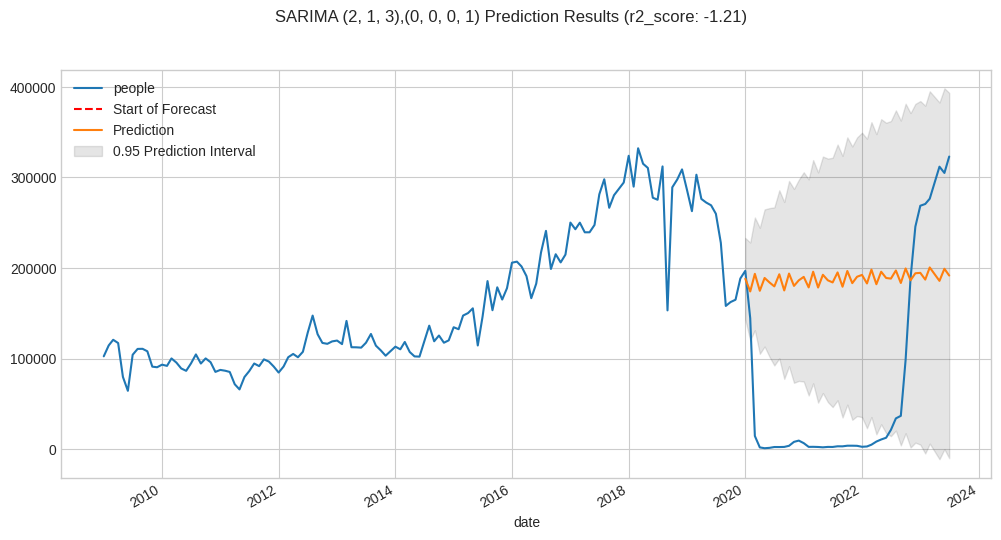

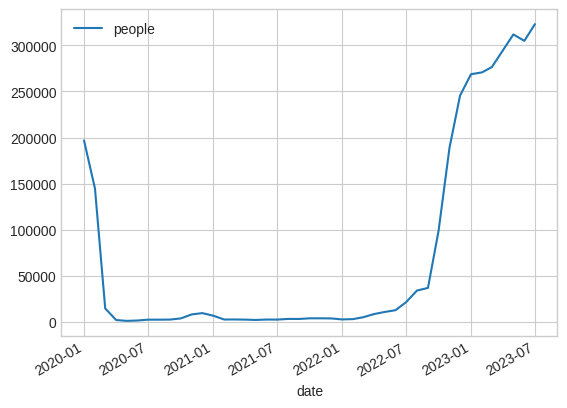

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
practice_data.plot(ax=ax);
ax.vlines('2023-01-01', 0, 700, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order},{auto_arima_model.seasonal_order} Prediction Results (r2_score: {round(r2, 2)})')

test_data.plot()

In [ ]:
model = Prophet()

# 향후 6개월간의 날짜 생성
future = model.make_future_dataframe(periods=6, freq='M', include_history=False)

# 향후 6개월간의 출국자 수 예측
forecast = auto_arima_model.predict(future)

# 예측 결과 시각화
fig = model.plot(forecast)
plt.title("Forecasted Departure Trends (2023-08 to 2024-02)")
plt.xlabel("Date")
plt.ylabel("Departure")
plt.show()

# 향후 6개월간의 예측값
future_forecast = forecast[['ds', 'yhat']].tail(6)
print(future_forecast)